In [2]:
import numpy as np
from typing import Union, Iterable, Sized, Tuple
import torch
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import matplotlib.pyplot as plt
import math
import os
import random
import logging
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary

from data_processing.data_loader import *
from model.activation_layers import ExULayer, ReLULayer, LipschitzMonotonicLayer
from model.model_network import HierarchNeuralAdditiveModel,NeuralAdditiveModel
from utils.model_architecture_type import get_defult_architecture_phase1, get_defult_architecture_phase2
from training.trainer import Trainer
from utils.utils import define_device, seed_everything
from utils.model_parser import parse_args

In [2]:
# os.environ["WANDB_NOTEBOOK_NAME"] = "nam_wandb.ipynb"

# import wandb
# wandb.login()

In [3]:
# Ensure deterministic behavior
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define the Data Loading and Model

In [4]:
def get_synthetic_data_phase1(num_exp=10, in_features=10):
#     # Simulate independent variables, x0,...,x4 from a Uniform distribution on [−1, 1]
#     X_uniform = Uniform(0, 3).sample((num_exp, in_features-5))
    
#     # Simulate features x5 and x6 from a Normal distribution with mean=0 and std=1
#     X_normal = torch.normal(1.5, 0.5, (num_exp, 5))
    
#     # Combine the uniform and normal features
#     X = torch.cat([X_uniform, X_normal], dim=1)
    X = Uniform(0, 3).sample((num_exp, in_features))
    print(X.shape)
    
    # creating y_1
    # y_1 = X[:, 0] + 0.5*(3*(X[:, 1]**2)-1) + 0.5*(X[:, 2]**3)
    y_1 = X[:, 0] + 2*(X[:, 1]**2) + (1/3)*(X[:, 2]**3)
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (2/3) * torch.log(100 * X[:, 5].abs()) + torch.cos(5 * X[:, 6])
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # creating y_3
    y_3 = (3/4) * torch.exp(-4 * X[:, 7].abs()) + 0.5*(torch.sin(5 * X[:, 8])+1)
    y_3 = y_3.reshape(-1, 1)
    
    # creating y_4
    y_4 = torch.exp(0.5 * X[:, 5]) + 0.5*(X[:, 2]**2)
    y_4 = y_4.reshape(-1, 1)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2, y_3, y_4], dim=1)
    print(y.shape)
    
    return X, y


def get_synthetic_data_phase2(X_input):
    
    # creating y_1
    y_1 = - X_input[:, 0] - 2*X_input[:, 2]
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = 3*X_input[:, 1]
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2], dim=1)
    print(y.shape)
    
    return y


def make_loader(X, y, batch_size):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader


X, y_phase1 = get_synthetic_data_phase1(num_exp=3, in_features=10)
y_phase2 = get_synthetic_data_phase2(y_phase1)

torch.Size([3, 10])
torch.Size([3, 4])
torch.Size([3, 2])


In [5]:
# Loss function for regression
def feature_loss(fnn_out, lambda_=0.):
    return lambda_ * (fnn_out ** 2).sum() / fnn_out.shape[1]

def penalized_mse(logits, truth, fnn_out, feature_penalty=0.0):
    feat_loss = feature_loss(fnn_out, feature_penalty)
    mse_loss = F.mse_loss(logits.view(-1), truth.view(-1))
    #print('mse_loss:', mse_loss)
    #print('feat_loss:',feat_loss)
    loss = mse_loss+feat_loss
    return loss

def l1_penalty(params, l1_lambda):
    l1_norm =  torch.stack([torch.linalg.norm(p, 1) for p in params], dim=0).sum()
    return l1_lambda*l1_norm

def l2_penalty(params, l1_lambda):
    l2_norm =  torch.stack([torch.linalg.norm(p, 2) for p in params], dim=0).sum()
    return l1_lambda*l2_norm

# Define Training Logic

In [6]:
def train(model, loader, criterion, optimizer, config):
    
    # Run training and track with wandb
#    total_batches = len(loader) * config['epochs']
#    batch_ct = 0
    loss_history = []

    for epoch in tqdm(range(config['epochs'])):
        epoch_loss_history = []
        for _, (X, y) in enumerate(loader):
            loss = train_batch(X, y, model, optimizer, criterion)
#            batch_ct += 1
            epoch_loss_history.append(loss)
#             # Report metrics every 5th batch
#             if ((batch_ct + 1) % 5) == 0:
#                 print(f"Epoch {epoch} | Batch {batch_ct + 1} | Total Loss: {loss:.5f}")

        avg_loss = sum(epoch_loss_history) / len(loader)
        loss_history.append(avg_loss)
    
        if epoch%100==0:
            print(f"Epoch {epoch} | Total Loss: {avg_loss:.5f}")
        
    return loss_history
        
def train_batch(X, y, model, optimizer, criterion):    
    X, y = X.to(device), y.to(device)
    # Forward pass
    logits, phase1_gams_out, phase2_gams_out = model(X)
    loss = criterion(logits, y, phase2_gams_out, feature_penalty=0.0002)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()
    
    if 0:
        print('predict outputs shape:',logits.shape)
        print('true outputs shape:',y.shape)
        print('fnns_out shape:',fnns_out.shape)

    return loss


# Define the Experiment

In [7]:
# define experiment
def define_experiment(ActivateLayers_pase1='ReLU', ActivateLayers_pase2=None):
    config = dict(
                epochs=2000,#2000, #100
                batch_size=1024, #128
                learning_rate=0.0035,
                weight_decay=0.0001,
                num_exp = 50000,
                in_features = 10,    
                seed=42,
                hierarch_net=True,
                task_type="regression",
                dataset="gen_uniform_distribution_data",
                model_architecture="multi_output_NAM"
                )
    
    if ActivateLayers_pase2 is not None:
        hirarchical_net = [ActivateLayers_pase1, ActivateLayers_pase2]
    else:
        hirarchical_net = [ActivateLayers_pase1]
    config['hirarchical_net'] = hirarchical_net

    for phase in range(len(hirarchical_net)):
        if hirarchical_net[phase] == 'ReLU':
            config[f'first_ActivateLayer_phase{phase+1}'] = 'ReLU'
            config[f'first_hidden_dim_phase{phase+1}'] = 64           
            config[f'shallow_phase{phase+1}'] = False
            config[f'hidden_ActivateLayer_phase{phase+1}'] = 'ReLU'
            config[f'hidden_dim_phase{phase+1}'] = [64, 32]
            config[f'hidden_dropout_phase{phase+1}'] = 0.2
            config[f'feature_dropout_phase{phase+1}'] = 0.3
            config[f'featureNN_arch_phase{phase+1}'] = 'multi_output' #'single_to_multi_output'
            config[f'weight_norms_kind_phase{phase+1}'] = None
            config[f'group_size_phase{phase+1}'] = None
            config[f'monotonic_constraint_phase{phase+1}'] = None
            if phase==0:
                config['latent_dim'] = 4
            else:
                config['output_dim'] = 2

        elif hirarchical_net[phase] == 'ExU':
            config[f'first_ActivateLayer_phase{phase+1}'] = 'ExU'
            config[f'first_hidden_dim_phase{phase+1}'] = 1024           
            config[f'shallow_phase{phase+1}'] = True
            config[f'hidden_dropout_phase{phase+1}'] = 0.4
            config[f'feature_dropout_phase{phase+1}'] = 0.2
            config[f'featureNN_arch_phase{phase+1}'] = 'multi_output'
            config[f'weight_norms_kind_phase{phase+1}'] = None
            config[f'group_size_phase{phase+1}'] = None
            config[f'monotonic_constraint_phase{phase+1}'] = None
            if phase==0:
                config['latent_dim'] = 4
            else:
                config['output_dim'] = 2

        elif hirarchical_net[phase] == 'LipschitzMonotonic':
            config[f'first_ActivateLayer_phase{phase+1}'] = 'LipschitzMonotonic'
            config[f'first_hidden_dim_phase{phase+1}'] = 128           
            config[f'shallow_phase{phase+1}'] = False
            config[f'hidden_ActivateLayer_phase{phase+1}'] = 'LipschitzMonotonic'
            config[f'hidden_dim_phase{phase+1}'] = [128, 64]
            config[f'hidden_dropout_phase{phase+1}'] = 0
            config[f'feature_dropout_phase{phase+1}'] = 0
            config[f'featureNN_arch_phase{phase+1}'] = 'multi_output'
            config[f'weight_norms_kind_phase{phase+1}'] = "one-inf"
            config[f'group_size_phase{phase+1}'] = 2
            config[f'monotonic_constraint_phase{phase+1}'] = None
            if phase==0:
                config['latent_dim'] = 4
            else:
                config['output_dim'] = 2
                
    return config

In [8]:
def make(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_synthetic_data_phase1(num_exp=config['num_exp'], in_features=config['in_features'])
    Y = get_synthetic_data_phase2(y)

    # Make the model
    if len(config['hirarchical_net']) == 2:
        print("Training Hierarchical NAM...")
        print(f"Phase1 activation layers: {config['hirarchical_net'][0]}\nPhase2 activation layers: {config['hirarchical_net'][1]}")
        
        train_loader = make_loader(X, Y, batch_size=config['batch_size'])
        
        model = HierarchNeuralAdditiveModel(
                            num_inputs= config['in_features'],
                            task_type= config['task_type'],
                            hierarch_net= config['hierarch_net'],
                      #phase1 - latent_features:
                            num_units_phase1= config['first_hidden_dim_phase1'],
                            hidden_units_phase1= config['hidden_dim_phase1'],
                            hidden_dropout_phase1 = config['hidden_dropout_phase1'],
                            feature_dropout_phase1 = config['feature_dropout_phase1'],
                            shallow_phase1 = config['shallow_phase1'],     
                            first_layer_phase1 = config['first_ActivateLayer_phase1'],
                            hidden_layer_phase1 = config['hidden_ActivateLayer_phase1'],
                            latent_var_dim = config['latent_dim'],
                            featureNN_architecture_phase1 = config['featureNN_arch_phase1'],
                            weight_norms_kind_phase1 = config['weight_norms_kind_phase1'],
                            group_size_phase1 = config['group_size_phase1'],
                            monotonic_constraint_phase1 = config['monotonic_constraint_phase1'],
                      #phase2 - final outputs:
                            num_units_phase2 = config['first_hidden_dim_phase2'],
                            hidden_units_phase2 = config['hidden_dim_phase2'],
                            hidden_dropout_phase2 = config['hidden_dropout_phase2'],
                            feature_dropout_phase2 = config['feature_dropout_phase2'],
                            shallow_phase2 = config['shallow_phase2'],
                            first_layer_phase2 = config['first_ActivateLayer_phase2'],
                            hidden_layer_phase2 = config['hidden_ActivateLayer_phase2'],        
                            output_dim = config['output_dim'],
                            featureNN_architecture_phase2 = config['featureNN_arch_phase2'],
                            weight_norms_kind_phase2 = config['weight_norms_kind_phase2'],
                            group_size_phase2 = config['group_size_phase2'],
                            monotonic_constraint_phase2 = config['monotonic_constraint_phase2'],
                            ).to(device)
    else:
        print('Training NAM...')
        print(f"Activation layers: {config['hirarchical_net'][0]}")
        
        train_loader = make_loader(X, y, batch_size=config['batch_size'])
        
        model = NeuralAdditiveModel(num_inputs= config['in_features'],
                     num_units= config['first_hidden_dim_phase1'],
                     hidden_units= config['hidden_dim_phase1'],
                     hidden_dropout = config['hidden_dropout_phase1'],
                     feature_dropout = config['feature_dropout_phase1'],
                     shallow = config['shallow_phase1'],     
                     first_layer = config['first_ActivateLayer_phase1'],
                     hidden_layer = config['hidden_ActivateLayer_phase1'],
                     num_classes = config['latent_dim'],
                     architecture_type = config['featureNN_arch_phase1'],
                     weight_norms_kind = config['weight_norms_kind_phase1'],
                     group_size = config['group_size_phase1'], 
                     monotonic_constraint = config['monotonic_constraint_phase1'],        
                     ).to(device)
    
    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'],
                                )
    
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)
    
    return model, train_loader, criterion, optimizer

In [9]:
def visualize_gam(model, x_values, input_dim, output_dim, config, vis_lat_features = False):
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    feature_output_max = {} 
    feature_output_min = {}

    for j in range(output_dim):
        feature_output_max[f'output_{j}'] = []
        feature_output_min[f'output_{j}'] = []

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if len(config['hirarchical_net']) == 2:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                feature_output_max[f'output_{j}'].append(max(feature_output)) 
                feature_output_min[f'output_{j}'].append(min(feature_output))

    for i in range(input_dim):
        with torch.no_grad(): 
            for j in range(output_dim):
                ax1 = axes[i, j]
                if len(config['hirarchical_net']) == 2:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Feature {i+1}')
                ax1.set_title(f'Feature {i+1} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')
                ax1.set_ylim([min(feature_output_min[f'output_{j}'])*1.3, max(feature_output_max[f'output_{j}'])*1.3])

    plt.tight_layout()
    plt.show()
    return

# Run

In [10]:
ActivateLayers_pase1 ='ReLU' # ReLU, ExU, LipschitzMonotonic, ExU_ReLU
ActivateLayers_pase2 ='LipschitzMonotonic' # ReLU, ExU, LipschitzMonotonic, ExU_ReLU

config = define_experiment(ActivateLayers_pase1='ReLU', ActivateLayers_pase2='LipschitzMonotonic')

# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make(config)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

if 0:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel()} parameters')
if 0:
    print(summary(model,input_size=(1, 10)))

# train the model
# Initialize the Trainer class
trainer = Trainer(
        model=model,
        optimizer='Adam',
        loss_function=None,
        lr_scheduler='NoScheduler', 
        scheduler_params=None,
        eval_metric=None, 
        epochs=config['epochs'], 
        batch_size=config['batch_size'], 
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'], 
        l1_lambda_phase1=0,
        l1_lambda_phase2=0,
        l2_lambda_phase1=0,
        l2_lambda_phase2=0.0002,
        eval_every=100,
        device_name="auto"
)

# Run the training phase
loss_history = trainer.train(train_loader)



#loss_history = train(model, train_loader, criterion, optimizer, config)
# loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

# plt.figure(figsize=(12, 6))
# plt.plot(loss_history_np)
# plt.legend(['Loss'])
# plt.show()

# # Generate input values for plotting
# x_values = torch.linspace(0, 4, 500).reshape(-1, 1)  # 100 points between -1 and 1

# input_dim = config['latent_dim']
# output_dim = config['output_dim']
# visualize_gam(model, x_values, input_dim, output_dim, config)

torch.Size([50000, 10])
torch.Size([50000, 4])
torch.Size([50000, 2])
Training Hierarchical NAM...
Phase1 activation layers: ReLU
Phase2 activation layers: LipschitzMonotonic


<ipython-input-4-2fa201bc4093>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
  0%|          | 0/2000 [00:00<?, ?it/s]

Number of parameters: 265884


  0%|          | 1/2000 [00:19<10:55:26, 19.67s/it]

Epoch 0 | Total Loss: 45.22864


  1%|          | 11/2000 [03:12<9:40:13, 17.50s/it]


KeyboardInterrupt: 

In [3]:
def visualize_gam_with_true_outputs(model, x_values, input_dim, output_dim, vis_lat_features = False):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    x_values = x_values.to(device)
    
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    feature_output_max = {} 
    feature_output_min = {}

    for j in range(output_dim):
        feature_output_max[f'output_{j}'] = []
        feature_output_min[f'output_{j}'] = []

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                feature_output_max[f'output_{j}'].append(max(feature_output)) 
                feature_output_min[f'output_{j}'].append(min(feature_output))

    for i in range(input_dim):
        with torch.no_grad(): 
            for j in range(output_dim):
                ax1 = axes[i, j]
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Feature {i+1}')
                ax1.set_title(f'Feature {i+1} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')
                ax1.set_ylim([min(feature_output_min[f'output_{j}'])*1.3, max(feature_output_max[f'output_{j}'])*1.3])

    plt.tight_layout()
    plt.show()
    return

In [4]:
args = parse_args()

In [ ]:
# Generate input values for plotting
x_values = torch.linspace(0, 3, 1000).reshape(-1, 1)  # 100 points between -1 and 1

input_dim = args.latent_dim
output_dim = args.output_dim
visualize_gam(model, x_values.to(device), input_dim, output_dim, vis_lat_features = False)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_gam(model, x_values.to(device), input_dim, output_dim, vis_lat_features = True)

In [14]:
X, y_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(5000, args.in_features)
y_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1)

torch.Size([5000, 10])
torch.Size([5000, 4])
torch.Size([5000, 2])


In [19]:
ls = [i for i in range(10)]
ls

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

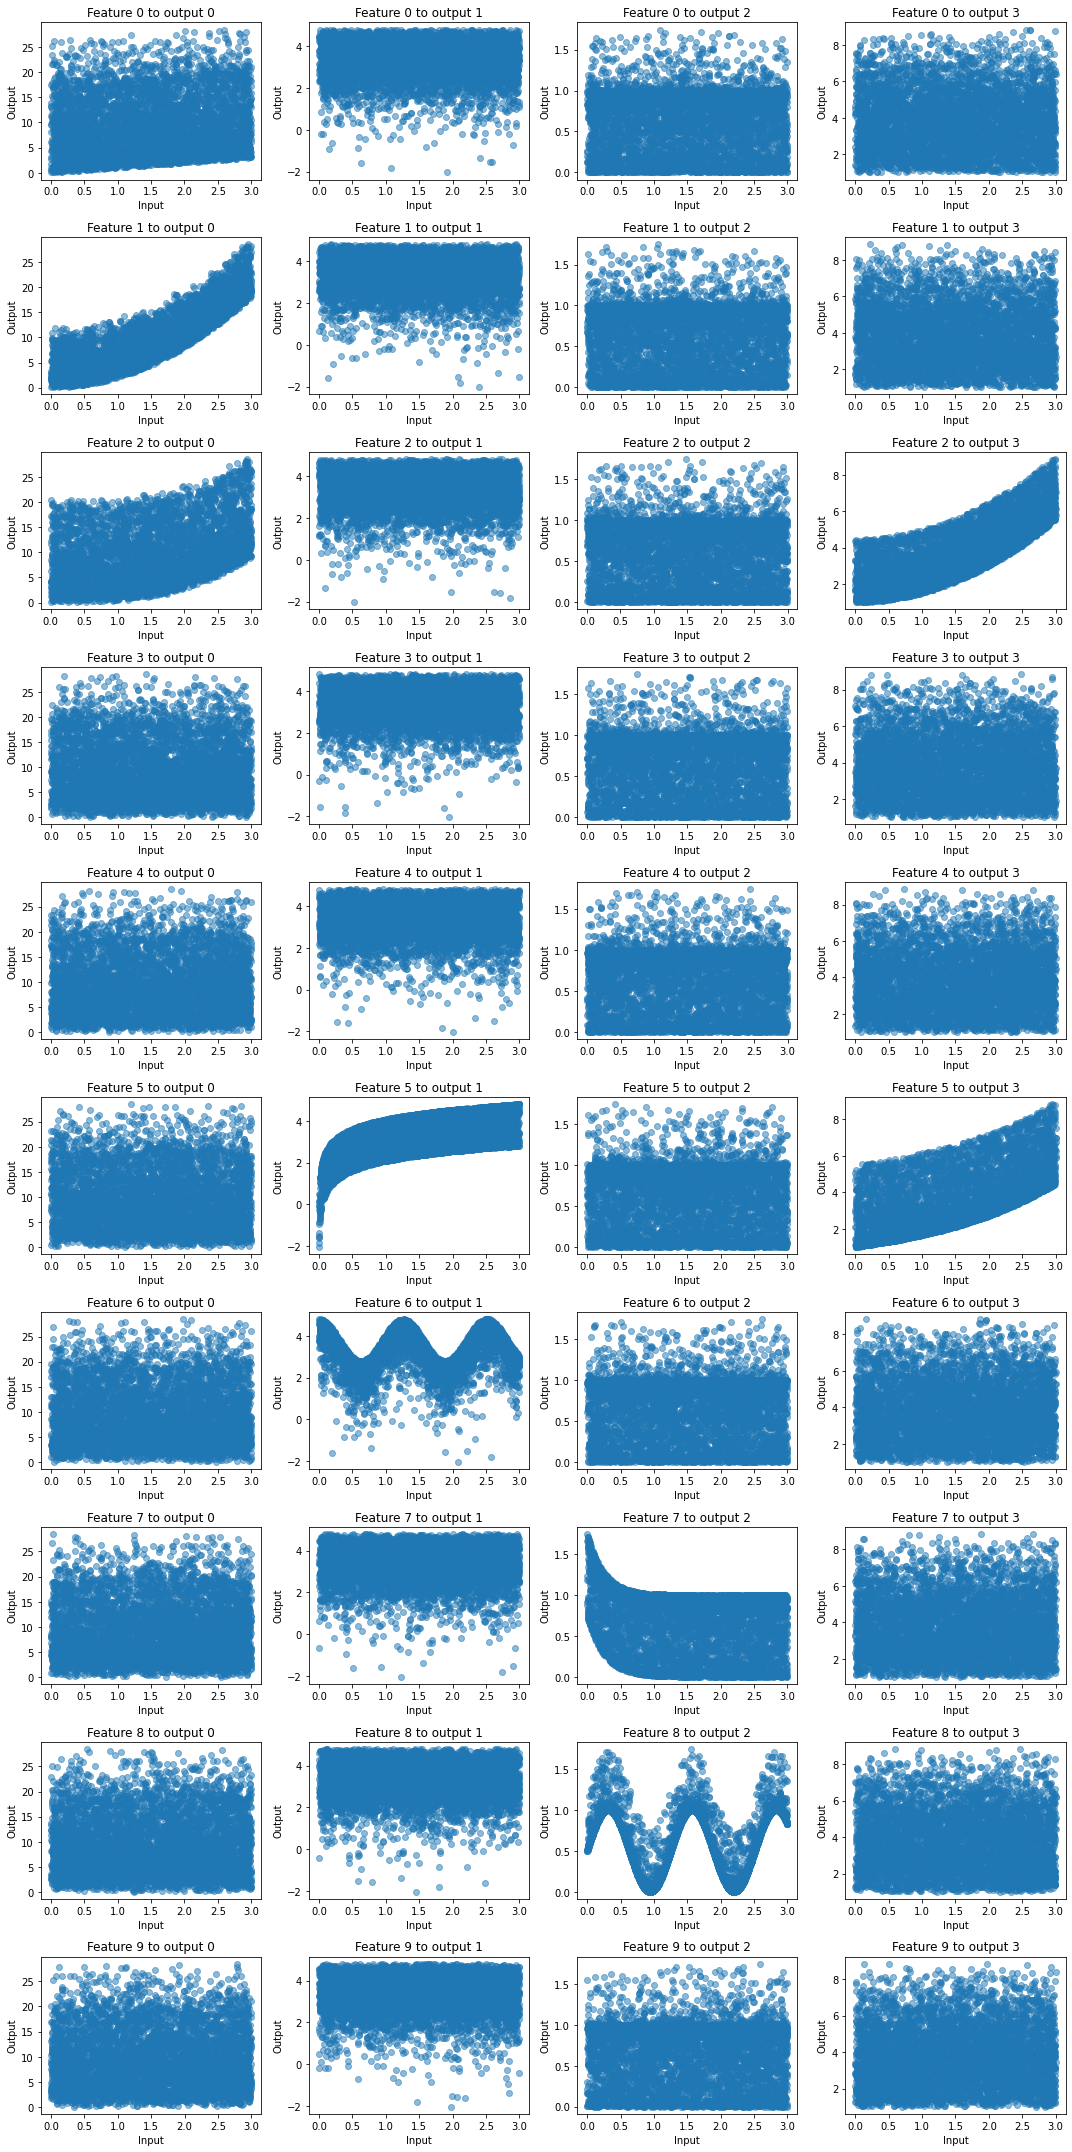

In [21]:
# Number of features and outputs you want to plot
features_to_plot = [i for i in range(10)]  # indices of features to plot (adjust as needed)
num_outputs = y_phase1.shape[1]  # number of outputs (y_1, y_2, y_3, y_4)

# Create a grid of subplots
fig, axes = plt.subplots(len(features_to_plot), num_outputs, figsize=(15,30))

# Plotting loop
for i, feature_idx in enumerate(features_to_plot):
    for j in range(num_outputs):
        axes[i, j].scatter(X[:, feature_idx], y_phase1[:, j], alpha=0.5)
        axes[i, j].set_title(f'Feature {feature_idx} to output {j}')
        axes[i, j].set_xlabel('Input')
        axes[i, j].set_ylabel('Output')

# Adjust layout
plt.tight_layout()
plt.show()